In [1]:
import numpy as np
from scipy.fftpack import fft,ifft,fftshift,ifftshift,fftfreq
from scipy.constants import c,pi
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.style.use('bmh')

## Fiber parameters

In [2]:
L = 1000              # Fiber length [m]
gamma = 10e-3         # Nonlinear coefficient [1/m/W]
beta2 = 1e-25         # The group-velocity dispersion [sec^2/m]
loss = 0.2            # Losses [dB/km]
alpha = loss/4.3429e3 # Attenuation coefficient [1/m]

## Input pulse (Part 1)

In [3]:
P0 = 1                # Peak power of the input pulse [W]
T0 = 12.8e-12         # Pulse half-width [sec]
C = 0                 # Chirp parameter
m = 1                 # Degree of edge sharpness (only for super-Gaussian pulses!)

## Caracteristic lengths

In [4]:
LD = T0**2/np.abs(beta2)       # Dispersion length [m]
LNL = 1/(gamma*P0)             # Nonlinearity length [m]

print(f"-> The fiber length is : {L} m")
print(f"-> The dispersion length is : {LD} m")
print(f"-> The nonlinearity length is : {LNL} m")

-> The fiber length is : 1000 m
-> The dispersion length is : 1638.4 m
-> The nonlinearity length is : 100.0 m


## Time grids

In [5]:
n = 2**15                        # Number of grid points
twidth = 200*T0                  # Width of time window [sec]
dt = twidth/n                    # Time step [sec]
T = np.linspace(-n/2,n/2-1,n)*dt # Time grid [sec]

## Frequency grid

In [6]:
f = np.linspace(-n/2,n/2-1,n)/(n*dt)     # Frequency grid [Hz]
omega = 2*pi*f                           # Angular frequency [rad/sec]
df = 1/(n*dt)                            # Frequency resolution [Hz]

## Space grids

In [7]:
nz = 2**8;                       # Number of space steps
z  = np.linspace(0,L,nz)         # Space grid [m]
dz = z[1]-z[0]                   # Space step [m]

## Useful functions

In [8]:
def sech(T):
    return (1+0j)/np.cosh(T)
    
def GaussianPulse(time,power,duration,chirp,order):
    return np.sqrt(power)*np.exp(-(1+1j*chirp)/2 * (time/duration)**(2*order))
    
def SechPulse(time,power,duration,chirp):
    return np.sqrt(power)*sech(T/T0)*np.exp(0.5j*chirp*(time/duration)**2)

def getSpectrumFromPulse(dt,E0):
    return fftshift(fft(E0))*dt
    
def getPulseFromSpectrum(dt,S0):
    return ifft(ifftshift(S0))/dt

## Input pulse (Part 2)

In [9]:
E0 = GaussianPulse(T,P0,T0,C,m)         # Initial pulse E0(t, z=0)
S0 = getSpectrumFromPulse(dt, E0)       # Initial pulse spectrum S0(t,z=0)

## Nonlinear propagation

In [10]:
E = np.zeros((n,nz))*(1+0j)
S = np.zeros((n,nz))*(1+0j)

E[:,0] = E0
S[:,0] = S0

D = -alpha/2 + 1j*beta2/2*omega**2        # Linear operator (losses and dispersion)
pulse = E0
for i in range(nz):
    pulse*=np.exp(1j*gamma*abs(pulse)**2*dz)
    spectrum = getSpectrumFromPulse(dt,pulse)*np.exp(D*dz)
    pulse = getPulseFromSpectrum(dt,spectrum)
    #Stor
    E[:,i] = pulse
    S[:,i] = spectrum

Ef = E[:,-1]       # Final pulse Ef(t, z=L)
Sf = S[:,-1]       # Final pulse spectrum Sf(t, z=L)

## Plot results

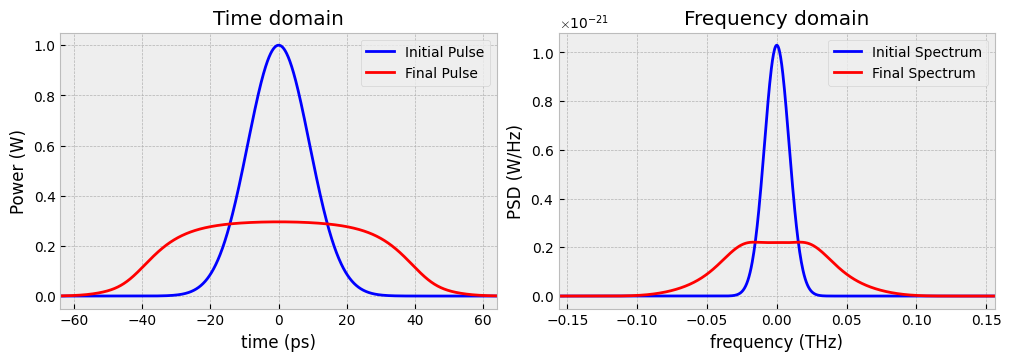

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,layout="constrained",figsize=(10, 3.5))
ax1.plot(T*1e+12, np.abs(E0)**2, color='blue',label="Initial Pulse")
ax1.plot(T*1e+12, np.abs(Ef)**2, color='red',label="Final Pulse")
ax1.set(xlabel='time (ps)', ylabel='Power (W)', title='Time domain')
ax1.legend()
ax1.set_xlim([-5*T0*1e12,5*T0*1e12])

ax2.plot(f*1e-12,np.abs(S0)**2, color='blue',label="Initial Spectrum")
ax2.plot(f*1e-12,np.abs(Sf)**2, color='red',label="Final Spectrum")
ax2.set(xlabel='frequency (THz)', ylabel='PSD (W/Hz)', title='Frequency domain')
ax2.legend()
ax2.set_xlim([-2*1e-12/T0,2*1e-12/T0])
ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))


3.2079135600434347e-11


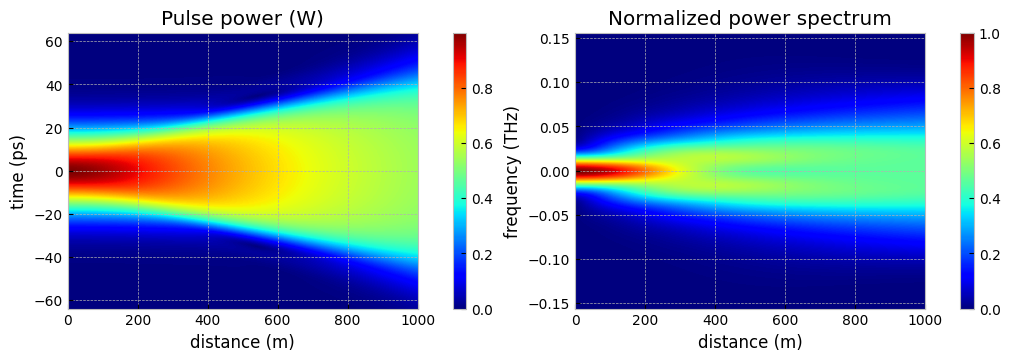

In [50]:
fig, (ax3,ax4) = plt.subplots(1,2,layout="constrained",figsize=(10, 3.5))
im1 = ax3.imshow(np.abs(E), extent=[z[0],z[-1],T[0]*1e12,T[-1]*1e12], aspect='auto',cmap='jet')
ax3.set(xlabel='distance (m)', ylabel='time (ps)',title='Pulse power (W)')
ax3.set_ylim([-5*T0*1e12,5*T0*1e12])
fig.colorbar(im1)
im2 = ax4.imshow(np.abs(S)/np.max(np.abs(S)), extent=[z[0],z[-1],f[0]*1e-12,f[-1]*1e-12],aspect='auto',cmap='jet')
ax4.set(xlabel='distance (m)', ylabel='frequency (THz)',title='Normalized power spectrum')
ax4.set_ylim([-2*1e-12/T0,2*1e-12/T0])
fig.colorbar(im2)